<a href="https://colab.research.google.com/github/Vibertexs/Tensorflow-Projects/blob/main/Drug_Discovery_with_GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performing Drug Discovery with GNNs

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py

import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

!pip install --pre deepchem
import deepchem

!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/delaney-processed.csv
!wget https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/tox21.csv.gz

import gzip
import shutil
with gzip.open('tox21.csv.gz', 'rb') as f_in:
    with open('tox21.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


from deepchem.utils.save import load_from_disk

# Data Structures
import numpy as np
import pandas as pd

# Graphing
import matplotlib.pyplot as plt

# Metrics
from sklearn.model_selection import train_test_split
from sklearn import metrics

# ML Models
from deepchem.models import GraphConvModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3501  100  3501    0     0  15422      0 --:--:-- --:--:-- --:--:-- 15355


python version: 3.7.10
INFO:conda_installer:python version: 3.7.10
remove current miniconda
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:conda_installer:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:conda_installer:done
installing miniconda to /root/miniconda
INFO:conda_installer:installing miniconda to /root/miniconda
done
INFO:conda_installer:done
installing rdkit, openmm, pdbfixer
INFO:conda_installer:installing rdkit, openmm, pdbfixer
added omnia to channels
INFO:conda_installer:added omnia to channels
added conda-forge to channels
INFO:conda_installer:added conda-forge to channels
done
INFO:conda_installer:done
conda packages installation finished!
INFO:conda_installer:conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda

--2021-06-22 20:38:45--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/delaney-processed.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 172.253.117.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/csv]
Saving to: ‘delaney-processed.csv.1’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.001s  

2021-06-22 20:38:45 (134 MB/s) - ‘delaney-processed.csv.1’ saved [96699/96699]

--2021-06-22 20:38:45--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/Deep%20Dives/AI%20%2B%20Healthcare/Sessions%201-5/Drug%20Discovery%20with%20GNNs/tox21.csv.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128,

# Determining Molecular Solubility

In [ ]:
solubility_data = pd.read_csv("delaney-processed.csv")
solubility_data.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


##Baseline: Predicting Solubility with Linear Regression


In [ ]:
solubility_data.columns

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')

In [ ]:
input_cols = [ 'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors','Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area'] 
output_cols = ['measured log solubility in mols per litre'] 

X = solubility_data[input_cols]
y = solubility_data[output_cols]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False, random_state=42)


In [ ]:
import sklearn
from sklearn import linear_model

lm = sklearn.linear_model.LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred = lm.predict(X_test)
metrics.r2_score(y_test, y_pred)

0.602491898293005

Text(0, 0.5, 'Predicted Log Solubility')

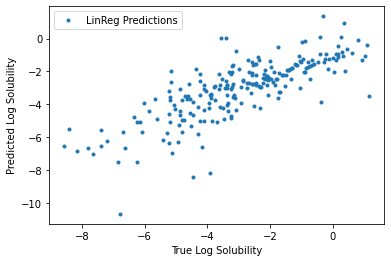

In [ ]:
plt.plot(y_test, y_pred, '.')
plt.legend(['LinReg Predictions'])
plt.xlabel("True Log Solubility")
plt.ylabel("Predicted Log Solubility")

In [ ]:
esol_pred = solubility_data['ESOL predicted log solubility in mols per litre'].loc[y_test.index]

In [ ]:
metrics.r2_score(y_test, esol_pred)

0.7839834529021221

#Graph Neural Networks



In [ ]:
loader = deepchem.data.CSVLoader(tasks=["measured log solubility in mols per litre"], 
                                 feature_field="smiles", 
                                 featurizer=deepchem.feat.ConvMolFeaturizer())
solubility_smiles_data = loader.create_dataset("delaney-processed.csv")

splitter = deepchem.splits.IndexSplitter()
sol_train_dataset, sol_test_dataset = splitter.train_test_split(solubility_smiles_data,
                                                                 frac_train=0.8)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
sol_gnn = GraphConvModel(dropout=0.2, n_tasks=1, mode = "regression")
sol_gnn.fit(sol_train_dataset,nb_epoch=1000)

0.08854052543640137

In [ ]:
gnn_pred = sol_gnn.predict(sol_test_dataset)
metrics.r2_score(y_test, gnn_pred)

0.7813204127744338

In [ ]:
gnn_pred_series = pd.Series(gnn_pred.squeeze(), index = y_test.index)
soluble = gnn_pred_series[gnn_pred_series > 0]
print (len(soluble)/len(gnn_pred_series))
solubility_data.loc[soluble.index]

0.11946902654867257


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
903,Ethyl propionate,-1.191,1,102.133,0,0,2,26.30,-0.660,CCOC(=O)CC
909,2-cyanoguanidine,0.361,1,84.082,2,0,0,88.19,-0.310,NC(N)=NC#N
919,Methyl acetate,-0.416,1,74.079,0,0,0,26.30,0.460,COC(=O)C
926,2-Methyl-2-pentanol,-1.308,1,102.177,1,0,2,20.23,-0.490,CCCC(C)(C)O
932,Pteridine,-0.906,2,132.126,0,2,0,51.56,0.020,c2cnc1ncncc1n2
940,Nitromethane,-0.042,1,61.040,0,0,0,43.14,0.260,CN(=O)=O
953,Ethyne,-0.252,1,26.038,0,0,0,0.00,0.290,C#C
954,"3,5-Dimethylpyridine",-2.098,1,107.156,0,1,0,12.89,0.380,Cc1cncc(C)c1
974,3-Methyl-2-butanone,-0.912,1,86.134,0,0,1,17.07,-0.120,CC(C)C(=O)C
983,Ethanol,0.020,1,46.069,1,0,0,20.23,1.100,CCO


#Determining Molecular Toxicity

In [ ]:
tox_data = pd.read_csv("/content/tox21.csv")
tox_data.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,TOX3028,CC(O)(P(=O)(O)O)P(=O)(O)O


In [ ]:
_, datasets, transformers = deepchem.molnet.load_tox21(featurizer='GraphConv')
tox_train_dataset, tox_valid_dataset, tox_test_dataset = datasets

In [ ]:
import warnings
warnings.filterwarnings('ignore')

tox_gnn = GraphConvModel(dropout=0.2, n_tasks=12, mode = "classification")
tox_gnn.fit(tox_train_dataset, nb_epoch=20)

0.7494463602701823

###Evaluating our Model


In [ ]:
tox_pred = tox_gnn.predict(tox_test_dataset)[:,:,1]
tox_pred

array([[0.3905988 , 0.07365133, 0.19927329, ..., 0.38099444, 0.30016765,
        0.16158064],
       [0.43459338, 0.22511867, 0.7307467 , ..., 0.8141992 , 0.7560565 ,
        0.8310102 ],
       [0.3530925 , 0.10199492, 0.25780785, ..., 0.861129  , 0.85087436,
        0.5323503 ],
       ...,
       [0.4142805 , 0.11059611, 0.8402634 , ..., 0.6118191 , 0.7642377 ,
        0.52978593],
       [0.10089765, 0.52886325, 0.02362225, ..., 0.08234042, 0.01533303,
        0.22204691],
       [0.25906047, 0.10784597, 0.56881267, ..., 0.09551933, 0.27502462,
        0.22000885]], dtype=float32)

In [ ]:
tox_pred_class = (tox_pred > 0.5)

In [ ]:
print ("Baseline Accuracy is 100% minus")
print (tox_test_dataset.y.mean())


print ("Accuracy")
right_ans = tox_pred_class == tox_test_dataset.y
print (right_ans.mean())

Baseline Accuracy is 100% minus
0.070578231292517
Accuracy
0.5266794217687075


###Identifying Safe Drugs

In [ ]:
any_toxic = tox_pred_class.any(axis=1) 
1 - (any_toxic.mean())

0.0714285714285714